In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/TSAI/tsai-gradcam-assignment')

from models import ResNet
from utils import common
from utils import modelhelper
device = common.get_dst_device()
model = ResNet.ResNet18().to(device)
modelhelper.print_model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Mounted at /content/drive


In [3]:
from utils import dataloader
from utils import transforms

train_loader = dataloader.setup_train_loader("data", transforms.train_transform)
test_loader = dataloader.setup_test_loader("data", transforms.test_transform)



Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([128, 3, 32, 32])


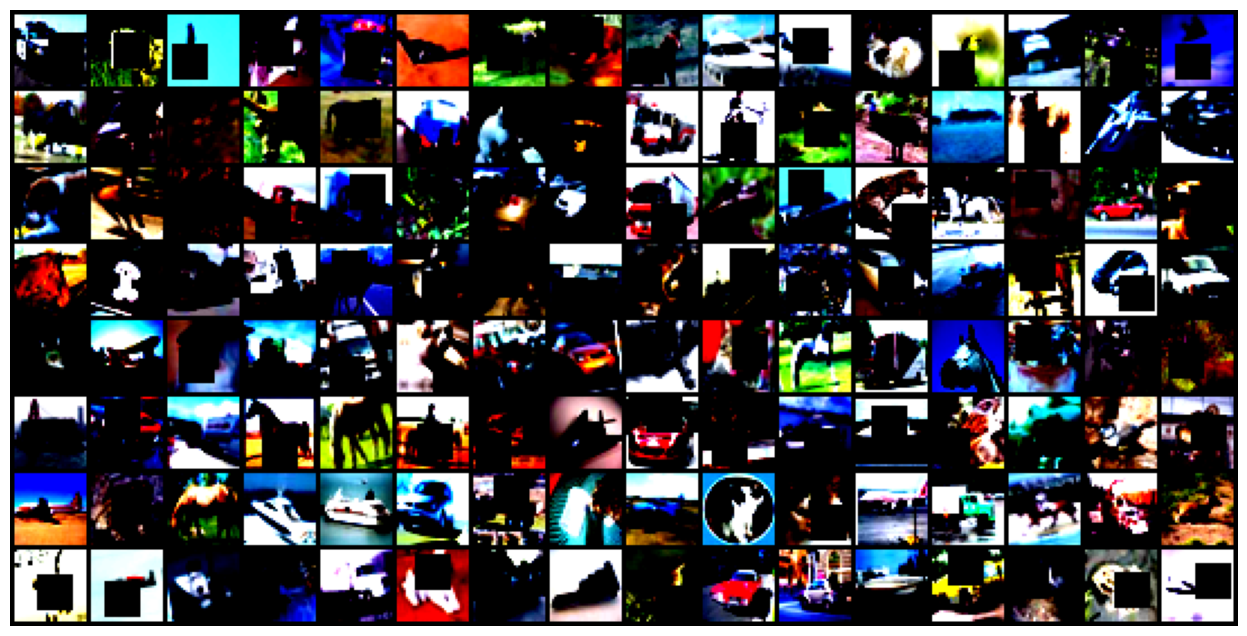

In [4]:
from utils import visualize
visualize.visualize_transforms(train_loader)


In [5]:
import torch.optim as optim
import torch.nn as nn

# Optimization algorithm to update the weights
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-01


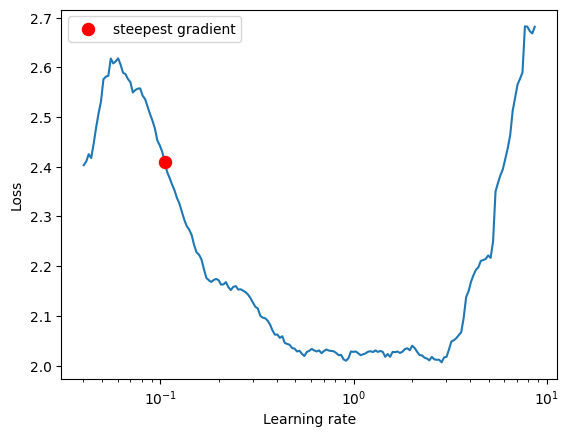

In [6]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder
lr_finder2 = LRFinder(model, optimizer, criterion, device=device)
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [7]:
EPOCHS = 20

MAX_LR = 1.05E-01    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

In [8]:
import torch.optim as optim
from utils import modelhelper
import torch_lr_finder as tlrf

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=EPOCHS,
                                                pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    train_acc, train_loss = modelhelper.train_model(model, device, train_loader, optimizer, criterion)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    # learning_rates.append((optimizer))
    scheduler.step()

    # Test the model's performance on test dataset and append the training loss and accuracy
    test_acc, test_loss = modelhelper.test_model(model, device, test_loader, criterion)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.3248 Batch_id=390 Accuracy=39.81: 100%|██████████| 391/391 [00:07<00:00, 54.43it/s]


Test set: Average loss: 0.0111, Accuracy: 5022/10000 (50.22%)

Epoch 2


Train: Loss=1.1441 Batch_id=390 Accuracy=55.55: 100%|██████████| 391/391 [00:07<00:00, 54.30it/s]


Test set: Average loss: 0.0082, Accuracy: 6287/10000 (62.87%)

Epoch 3


Train: Loss=0.8690 Batch_id=390 Accuracy=62.83: 100%|██████████| 391/391 [00:07<00:00, 55.16it/s]


Test set: Average loss: 0.0075, Accuracy: 6701/10000 (67.01%)

Epoch 4


Train: Loss=0.8546 Batch_id=390 Accuracy=68.04: 100%|██████████| 391/391 [00:06<00:00, 55.92it/s]


Test set: Average loss: 0.0063, Accuracy: 7224/10000 (72.24%)

Epoch 5


Train: Loss=0.8555 Batch_id=390 Accuracy=71.68: 100%|██████████| 391/391 [00:07<00:00, 52.70it/s]


Test set: Average loss: 0.0054, Accuracy: 7526/10000 (75.26%)

Epoch 6


Train: Loss=0.5902 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:07<00:00, 55.73it/s]


Test set: Average loss: 0.0059, Accuracy: 7476/10000 (74.76%)

Epoch 7


Train: Loss=0.7915 Batch_id=390 Accuracy=75.64: 100%|██████████| 391/391 [00:07<00:00, 53.63it/s]


Test set: Average loss: 0.0050, Accuracy: 7816/10000 (78.16%)

Epoch 8


Train: Loss=0.4399 Batch_id=390 Accuracy=77.44: 100%|██████████| 391/391 [00:07<00:00, 55.05it/s]


Test set: Average loss: 0.0043, Accuracy: 8085/10000 (80.85%)

Epoch 9


Train: Loss=0.6868 Batch_id=390 Accuracy=78.87: 100%|██████████| 391/391 [00:07<00:00, 55.29it/s]


Test set: Average loss: 0.0041, Accuracy: 8228/10000 (82.28%)

Epoch 10


Train: Loss=0.7356 Batch_id=390 Accuracy=80.05: 100%|██████████| 391/391 [00:07<00:00, 54.77it/s]


Test set: Average loss: 0.0040, Accuracy: 8233/10000 (82.33%)

Epoch 11


Train: Loss=0.4354 Batch_id=390 Accuracy=80.90: 100%|██████████| 391/391 [00:07<00:00, 54.71it/s]


Test set: Average loss: 0.0042, Accuracy: 8275/10000 (82.75%)

Epoch 12


Train: Loss=0.3506 Batch_id=390 Accuracy=82.18: 100%|██████████| 391/391 [00:07<00:00, 54.90it/s]


Test set: Average loss: 0.0047, Accuracy: 8123/10000 (81.23%)

Epoch 13


Train: Loss=0.5139 Batch_id=390 Accuracy=82.66: 100%|██████████| 391/391 [00:07<00:00, 54.91it/s]


Test set: Average loss: 0.0041, Accuracy: 8313/10000 (83.13%)

Epoch 14


Train: Loss=0.5130 Batch_id=390 Accuracy=83.34: 100%|██████████| 391/391 [00:07<00:00, 55.09it/s]


Test set: Average loss: 0.0032, Accuracy: 8576/10000 (85.76%)

Epoch 15


Train: Loss=0.5068 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [00:07<00:00, 54.12it/s]


Test set: Average loss: 0.0041, Accuracy: 8331/10000 (83.31%)

Epoch 16


Train: Loss=0.3459 Batch_id=390 Accuracy=84.48: 100%|██████████| 391/391 [00:07<00:00, 54.41it/s]


Test set: Average loss: 0.0033, Accuracy: 8586/10000 (85.86%)

Epoch 17


Train: Loss=0.3756 Batch_id=390 Accuracy=85.32: 100%|██████████| 391/391 [00:07<00:00, 54.13it/s]


Test set: Average loss: 0.0035, Accuracy: 8494/10000 (84.94%)

Epoch 18


Train: Loss=0.4174 Batch_id=390 Accuracy=85.97: 100%|██████████| 391/391 [00:07<00:00, 54.24it/s]


Test set: Average loss: 0.0033, Accuracy: 8649/10000 (86.49%)

Epoch 19


Train: Loss=0.2717 Batch_id=390 Accuracy=86.35: 100%|██████████| 391/391 [00:07<00:00, 54.79it/s]


Test set: Average loss: 0.0031, Accuracy: 8682/10000 (86.82%)

Epoch 20


Train: Loss=0.4316 Batch_id=390 Accuracy=86.57: 100%|██████████| 391/391 [00:07<00:00, 55.00it/s]


Test set: Average loss: 0.0040, Accuracy: 8378/10000 (83.78%)



In [ ]:
from utils import plots

plots.plot_results(train_accuracies, train_losses, test_accuracies, test_losses)

In [3]:
#import torch

#torch.save(model.state_dict(), "model.pth")


In [4]:
import torch
model.load_state_dict(torch.load("model.pth"), strict=False)

<All keys matched successfully>

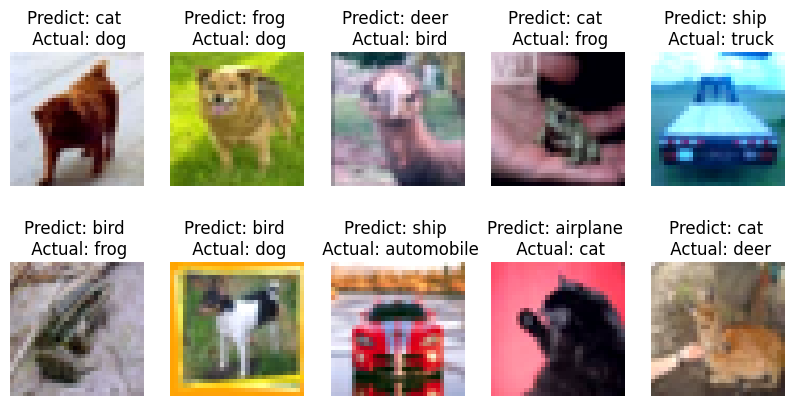

In [5]:
from utils import modelhelper
from utils import visualize
from torchvision import transforms

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Compose([transforms.Normalize(
        mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
        std=[1/0.23, 1/0.23, 1/0.23]
)])

# Plot the misclassified data
modelhelper.print_incorrect_preds(model, test_loader, device, inv_normalize, 20)

In [7]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=3fb1f77cc7ec6c898671ab632f59d7cf4a71022aba6230e394a1d6235558c505
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


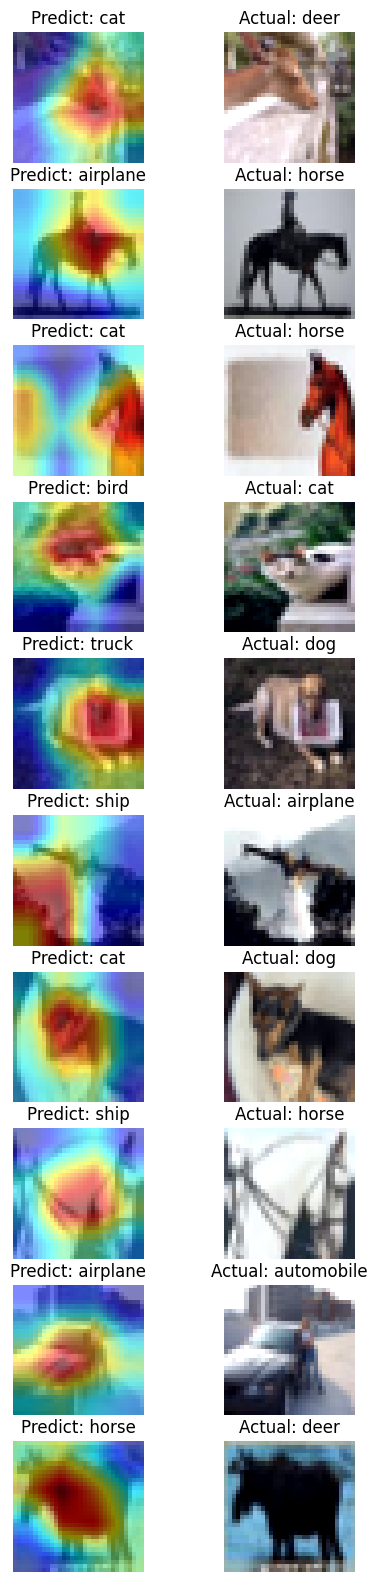

In [6]:
from utils import modelhelper
modelhelper.show_grad_cam_output(model, test_loader, device, inv_normalize)
